# Generative modelling in deep learning

Generative modelling in machine learning can aim at achieving different goals.

The first, obvious one is that a generative model can be used to generate more data, to be used afterwards by an other algorithm. While a generative model cannot create more information to solve the issue of having too small datasets, it could be used to solve anonymity questions. Typically, sharing a generative model trained on private data could allow the exploitation of the statistical property of this data without sharing the data itself (which can be protected by privacy matters for example).

Another goal is to use generative modelling to better understand the data at hand. This is based on the hypothesis that a model that successfully learned to generate (and generalize) a dataset should have internally learned some efficient and compressed representation of the information contained in the data. In this case, analysing a posteriori the learned representation may give us insights on the data itself.

The notion of a generative model however needs to be more formally specified, in order to work with. What does it mean for the model to generate data that "looks like" the original dataset? A mathematical formulation of that is necessary, in order to define a training objective that can be used efficiently. Having some expert rate the quality of all generated datapoints one by one is definitely not an option.

Thus, modelling our data and models as probability distributions comes to the rescue. If we consider our data as coming from some underlying probability distribution, that we will name $p_D$, our goal is thus to train our model to represent another probability distribution, which we will name $p_\theta$, that should be some good approximation of $p_D$. Given we only know $p_D$ through some set of realisations from it (the dataset), we can never hope to learn it exactly.

**Q1: Can you name some ways to compare two given distributions $p_D$ and $p_\theta$?**

> ### First thoughts
> <b>Nice property:</b> As the true probability distribution $p_{D}$ is intractable, we want in any desirable approximation $p_{\theta}(x)$ that if $x$ is not likely to be drawn from $p_{D}$ then it is the same for $p_{\theta}$
> ### Kullback-Leibler divergence
> $$ \text{KL}(p_{D} || p_{\theta}) = - \int_{-\infty}^{\infty} p_{D}(x) log\bigg( \frac{p_{D}(x)}{p_{\theta}(x)} \bigg)dx $$
> Te Kullback-Leibler divergence is simply the expected value of the loglikelihood ratio under the alternative hypothesis $p_{D}$. In consequence, $KL(p_{D} || p_{\theta})$ is a measure of the difficulty of this test problem, when $p_{\theta}$ is the null hypothesis. Because of the asymmetry between null and alternative hypothesis, the KL divergence is of course asymteric. In practice, the advantage of KL is that the <b>nice property</b> holds. The reason is KL kind of abhors regions where $p_{\theta}$ have non-null mass and $p_{D}$ has null mass ($p_{\theta}$ effect is disregarded). This might look like a bug, but it’s actually a feature in certain situations.
> ### Jenson-Shannon divergence
> $$\text{JSD}(p_{D} \parallel p_{\theta})= \frac{1}{2}KL(p_{D} \parallel M)+\frac{1}{2}KL(p_{\theta} \parallel M)$$
> where $M=\frac{1}{2}(p_{\theta}+p_{D})$. Although the Jenson-Shannon is symmetric, it doesn’t have the <b>nice property</b>. The reason is that JSD is well behaved both when $p(x)$ and $q(x)$ are small. This imples that it won’t penalize as much (smoothed version of KL) a distribution $q(x)$ from which you can sample values that are impossible in $p(x)$.
> ### Wasserstein distance 
It is based on optimal transportation and is a smoother measure compared to the two previous ones. It proved to be successful in several GAN implementations.

Most comparison methods can be separated into two kinds: those that compare the density of the distributions ($p_\theta(x)$ vs $p_D(x)$), and those that compare the values sampled from them directly.

**Q2: Given we want to use them as an optimisation objective, what are the caveats to keep in mind about these two kinds?**

DKL gives us inifity when two distributions are disjoint. The value of DJS has sudden jump, not differentiable at θ=0.

> <b>First method: Compare the density</b>
> While comparing distributions is a general measure that does not reflect local differences, it is very expensive in terms of computations for KL or JS.<br>
> <b>Second method: Compare the sampled values</b> 
While faster than the first method, sampling values has its own set of limitations. If too feaw samples are drawn, this leads to misleading results (notably overfitting). If too much are sampled, the computations get expensive quickly.

In this work, we will focus on two of the most widely used generative models based on deep neural networks: Generative Adversarial Networks (GANs) and Variational AutoEncoders (VAEs), in order to compare them and understand their strenghts and weaknesses.

### Generative Adversarial Networks

GANs structure is based on modelling the distribution $p_\theta$ as a learned deterministic function applied to a standard noise. Sampling from it is thus done as follows: first, some noise is sampled from a standard N-dimentional gaussian distribution: $\epsilon \sim \mathcal{N}(0;I)$, and then the output is computed as a deterministic function $x = f_\theta(\epsilon)$. The function $f_\theta$ is implemented as a neural network, $\theta$ representing its learned parameters.

**Q3: What is, a priori, the impact of the choice of N, the dimension of the input noise?**

> The choice of $N$ is motivated by the following:
> - If $N$ is too low, the problem is hardly learnable.
> - If $N$ is too high, it gets harder to learn or the latent space is too big to be meaningful.

By construction, this generator structure only allows sampling of the distribution $p_\theta$, and does not allow the computation of the density $p_\theta(x)$ (at least not without strong assumptions on $f_\theta$. Such a model seems to need a comparison method based on samples to be trained.

The smart idea of GANs is to instead use another neural network to model the objective. Another neural network is introduced: a classifier (that we call the discriminator) which is trained to differentiate examples from the dataset from examples generated by $p_\theta$. The reasoning is as follows:

The discriminator (whose output is denoted by $D(x)$) is trained using a classic discrimination loss, so that $D(x)$ can be interpreted as the probability that $x$ came from the real dataset:

$$ \mathcal{L}_D = \mathbb{E}_{p_D} \left[ -\log D(x) \right] + \mathbb{E}_{p_\theta} \left[ -\log \left(1-D(x)\right) \right] $$

From that, it can be shown that the optimal discriminator is given by $D(x) = \frac{p_D(x)}{p_\theta(x) + p_D(x)}$, and when reached its loss takes a specific value:

$$ \mathcal{L}_D = 2 \left( \log 2 - JSD(p_\theta \| p_D) \right) $$

So, training the generator network to *maximize* the same loss would, assuming the discriminator is always trained to optimality, minimize the JSD between $p_\theta$ and $p_D$, and thus bring $p_\theta$ closer to $p_D$.

**Q4: Can you anticipate a caveat of using the JSD as a training objective for the generator?**

> When $p_{D}$ and $p_{\theta}$ (the data distributions for the real and the generated images) are far apart, the gradient for their JS-divergence vanishes and in consequence: gradient descent will not be effective.

Having the generator trained to maximize $\mathcal{L}_D$ is equivalent to setting its training loss to $ \mathcal{L}_G = \mathbb{E}_{p_\theta} \log(1-D(x)) $.

**Q5: This loss only gives feedback to the generator on samples it generated, what can this imply?**

> During the training, the generator may collapse to a setting where it always produces same outputs (kind of "stuck in a bad local optima"). This is a common failure case for GANs, commonly referred to as Mode Collapse. Even though the generator might be able to trick the corresponding discriminator, it fails to learn to represent the complex real-world data distribution and gets stuck in a small space with extremely low variety.

We will now work on implementing a GAN on a simple toy problem, to get a feeling of its behavior and test our theoretical insights. For this we will use the `pytorch` library.

While a real problem would be generating images for example (each datapoint $x$ would then be a different image), this is a kind of task that easily requires intensive CPU/GPU power, and image datasets are difficult to visualize from a geometric point of view (even small images contains hundreds of pixels, and nobody can visualize points in a 100-dimensional space). So instead we will focus on points in the plane: each datapoint $x$ will actually be a couple of numbers $(x1, x2)$, and our target dataset will be 25 Gaussian distributions with small variance, distributed on a $5\times 5$ grid.

In [1]:
import torch
import numpy as np
import math

import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable

import copy

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# Our dataset is mathematically defined, we can generate batches on the fly and enjoy
# an infinite-size dataset
def generate_batch(batchlen):
    """
    This function generates a batch of length 'batchlen' from the 25-gaussian dataset.
    Multinomial: Tirage sans remise de chiifres? (indices [0, 1, 2, 3, 4])
    Tirer BATCHLEN fois batchlen de nombres compris entre 0 et 4
    return a torch tensor of dimensions (batchlen, 2)
    """
    # to sample from the gaussian mixture, we first sample the means for each point, then
    # add a gaussian noise with small variance
    samples = torch.multinomial(torch.tensor([0.2,0.2,0.2,0.2,0.2]), 2*batchlen, replacement=True)
    means = (2.0 * (samples - 2.0)).view(batchlen,2).type(torch.FloatTensor)
    return torch.normal(means, 0.05)

Let's plot a batch, to see what the dataset looks like.

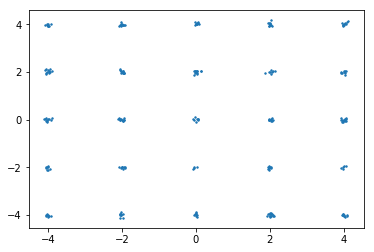

In [3]:
# Generate batch
batch = generate_batch(256)
# Plot
plt.scatter(batch[:,0], batch[:,1], s=2.0, label='Batch of data from our gaussian mixture dataset')
plt.show()

We now need to define our two neural networks, the generator and the discriminator. The generator will take as input a value $z$ sampled from a Gaussian prior, and output a value $x$ (thus a couple $(x_1,x_2)$). The discriminator takes as input a value $x$, and is a binary classifier.

When representing a binary classifier with a neural network, it is better for the last layer to consist of only a sigmoid activation, so that the output values will be between 0 and 1 and stand for the probability (according to the classifier) that the input is of the first class. The output is thus of the form $\mathrm{sigmoid}(h)$. The loss involves quantities such as $-\log(\mathrm{sigmoid}(h))$. For numerical stability reasons, it is recommended to rewrite the loss in order to make use of the $\mathrm{softplus}$ function defined by $\mathrm{softplus}(h) = \log(1 + \exp(h))$ and provided in PyTorch as `torch.softplus`.
As the $\mathrm{softplus}(h)$ formulation of the loss already contains the sigmoid activation, in practice the last layer of the discrimator network will not have any activation function (being just $h$).

In [4]:
def block(in_feat, out_feat, normalize=True, alpha = 0.2, inplace = False):
    """
    Construct a block layer consisting of a Linear layer, followed by a LeakyRelu.
    There is an option (normalize) to add a BatchNorm1D layer to provide stability
    for deeper architectures.

    Parameters:
    - in_feat (int): Number of in features
    - out_feat (int): Number of out features
    - normalize (bool): Wether to apply BatchNormalization

    Output:
    - layers (list): List of layers
    """
    # Linear layer
    layers = [nn.Linear(in_feat, out_feat)]
    # Batch Normalization
    if normalize: layers.append(nn.BatchNorm1d(out_feat, 0.8))
    # Leaky Relu
    layers.append(nn.LeakyReLU(alpha, inplace=True))

    return layers

class Generator(nn.Module):
    """
    This nn.Module sub-class encapsulates the generator part of our model.

    Attributes:
    - dim (int): Dimension of the original sample (2 in out case)
    - latent_dim (int): Dimension of the latent representation
    - model (nn.Sequential):
    - width (list of length 4):
    """
    def __init__(self, options):
        super(Generator, self).__init__()

        # Dimensions constant
        self.dim = options['dim']
        self.latent_dim = options['latent_dim']
        self.width = options['width_generator']

        # Create sequential model
        self.model = nn.Sequential(
            *block(self.latent_dim, self.width[0], normalize=False),
            *block(self.width[0], self.width[1]),
            nn.Linear(self.width[1], self.dim)
        )

    def __call__(self, z):
        """ Forward pass of z """
        return self.model(z)

    def generate(self, batchlen):
        """
        Generate a random
        - batch_len (int?):
        """
        z = torch.normal(torch.zeros(batchlen, self.latent_dim), 1.0)
        return self.__call__(z)

class DeepGenerator(nn.Module):
    """
    This nn.Module sub-class encapsulates the generator part of our model.

    Attributes:
    - dim (int): Dimension of the original sample (2 in out case)
    - latent_dim (int): Dimension of the latent representation
    - model (nn.Sequential):
    - width (list of length 4):
    """
    def __init__(self, options):
        super(DeepGenerator, self).__init__()

        # Dimensions constant
        self.dim = options['dim']
        self.latent_dim = options['latent_dim']
        self.width = options['width_generator']

        # Create sequential model
        self.model = nn.Sequential(
            *block(self.latent_dim, self.width[0], normalize=False),
            *block(self.width[0], self.width[1]),
            *block(self.width[1], self.width[2]),
            *block(self.width[2], self.width[3]),
            nn.Linear(self.width[3], self.dim)
        )

    def __call__(self, z):
        """ Forward pass of z """
        return self.model(z)

    def generate(self, batchlen):
        """
        Generate a random
        - batch_len (int?):
        """
        z = torch.normal(torch.zeros(batchlen, self.latent_dim), 1.0)
        return self.__call__(z)

class LinearDiscriminator(nn.Module):
    """
    This nn.Module sub-class encapsulates the Linear Discriminator part of our model.

    Attributes:

    - options['width']: length 3
    """
    def __init__(self, options):
        super(LinearDiscriminator, self).__init__()
        self.dim = options['dim']
        self.latent_dim = options['latent_dim']
        self.width = options['width_discriminator']

        self.model = nn.Sequential(
            *block(self.dim, self.width[0], inplace = True),
            *block(self.width[0], self.width[1], inplace = True),
            nn.Linear(self.width[1], 1),
            nn.Sigmoid()
        )

    def __call__(self, img):
        return self.model(img)

class DeepLinearDiscriminator(nn.Module):
    """

    """
    def __init__(self, options):
        super(DeepLinearDiscriminator, self).__init__()
        self.dim = options['dim']
        self.latent_dim = options['latent_dim']
        self.width = options['width_discriminator']

        self.model = nn.Sequential(
            *block(self.dim, self.width[0], inplace = True),
            *block(self.width[0], self.width[1], inplace = True),
            *block(self.width[1], self.width[2], inplace = True),
            *block(self.width[2], self.width[3], inplace = True),
            nn.Linear(self.width[3], 1),
            nn.Sigmoid()
        )

    def __call__(self, img):
        return self.model(img)


In [5]:
def training_total(opt):
    # Instanciate generator and its optimizer
    generator = Generator(opt) if opt['generator'] == 'shallow' else DeepGenerator(opt)
    optim_gen = torch.optim.Adam(generator.parameters(), lr=opt['lr'], betas=(0.5,0.9))
    
    # Instanciate discriminator and its optimizer
    discriminator = LinearDiscriminator(opt) if opt['discriminator'] == 'shallow' else DeepLinearDiscriminator(opt)
    optim_disc = torch.optim.Adam(discriminator.parameters(), lr=opt['lr'], betas=(0.5,0.9))

    # Define adversarial loss
    adversarial_loss = lambda x, y: (-y * torch.log(x) - (1-y)*torch.log(1-x) ).mean()
    
    # Discriminator and generator history
    disc_history = []
    gen_history = []
    
    # Create valid and fake tensors
    valid = Variable(torch.Tensor(opt['batch_size'], 1).fill_(1.0), requires_grad=True)
    fake = Variable(torch.Tensor(opt['batch_size'], 1).fill_(0.0), requires_grad=True)
    
    for i in range(0, opt['n_iter']):

        for _ in range(0, opt['train_ratio']):
            
            # DISCRIMINATOR
            # Optimizer
            optim_disc.zero_grad()
            batch = generate_batch(opt['batch_size'])
            real_batch = Variable(batch.type(torch.Tensor))

            ## DISCRIMINATOR LOSS

            ###  Generate data
            z = Variable(torch.normal(torch.zeros((opt['batch_size'], opt["latent_dim"])), 1.))
            generated_batch = generator(z)

            ### Compute real and fake loss
            real_loss = adversarial_loss(discriminator(real_batch), valid)
            fake_loss = adversarial_loss(discriminator(generated_batch.detach()), fake)

            ### Compute discriminator loss and backward
            disc_loss = (real_loss + fake_loss) / 2
            
            if _ == opt['train_ratio'] - 1: disc_history.append(disc_loss.item())

            disc_loss.backward()
            optim_disc.step()

        # GENERATOR
        ## Optimizer
        optim_gen.zero_grad()

        ## Compute here the generator loss, using fake_batch
        z = Variable(torch.normal(torch.zeros((opt['batch_size'], opt["latent_dim"])), 1.))
        generated_batch = generator(z)

        ## Backward pass
        g_loss = adversarial_loss(discriminator(generated_batch), valid)
        gen_history.append(g_loss.item())
        g_loss.backward()
        optim_gen.step()

        # Print progress
        if i%1000 == 0:
            print('step {}: discriminator: {:.3e}, generator: {:.3e}'.format(i, float(disc_loss), float(g_loss)))
            # plot the result
            batch = generate_batch(opt['batch_size'])
            real_batch = Variable(batch.type(torch.Tensor))
            real_batch = real_batch.detach()

            z = Variable(torch.normal(torch.zeros((opt['batch_size'], opt["latent_dim"])), 1.))
    
            fake_batch = generator(z)
            fake_batch = fake_batch.detach()

            plt.scatter(real_batch[:,0], real_batch[:,1], s=2.0, label='real data')
            plt.scatter(fake_batch[:,0], fake_batch[:,1], s=2.0, label='fake data')
            plt.show()
            
    return(generator, discriminator, disc_history, gen_history, real_batch, fake_batch)

In [6]:
# Basic
options_basic = {}
# Overall training
options_basic['n_iter'] = 4000
options_basic['batch_size'] = 512
options_basic['train_ratio'] = 3
options_basic['lr'] = 0.001
# Dimension
options_basic['latent_dim'] = 32
options_basic['dim'] = 2
# Discriminator
options_basic['discriminator'] = 'shallow'
options_basic['width_discriminator'] = [256, 128]
# Generator
options_basic['generator'] = 'shallow'
options_basic['width_generator'] = [128, 256]

# Deep Disc
options_deep_disc = copy.deepcopy(options_basic)
# Discriminator
options_deep_disc['discriminator'] = 'deep'
options_deep_disc['width_discriminator'] = [1024, 512, 256, 128]
# Generator
options_deep_disc['generator'] = 'shallow'
options_deep_disc['width_generator'] = [128, 256]

# Deep Gen
options_deep_gen = copy.deepcopy(options_basic)
# Discriminator
options_deep_gen['discriminator'] = 'shallow'
options_deep_gen['width_discriminator'] = [256, 128]
# Generator
options_deep_gen['generator'] = 'deep'
options_deep_gen['width_generator'] = [128, 256, 512, 1024]

# Basic
options_full = copy.deepcopy(options_basic)
# Discriminator
options_full['discriminator'] = 'deep'
options_full['width_discriminator'] = [1024, 512, 256, 128]
# Generator
options_full['generator'] = 'deep'
options_full['width_generator'] = [128, 256, 512, 1024]

step 0: discriminator: 6.737e-01, generator: 7.041e-01


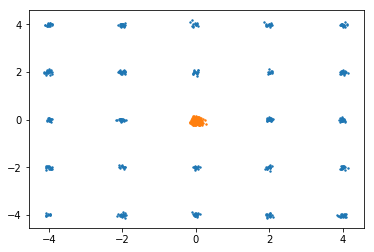

step 1000: discriminator: 5.146e-01, generator: 1.030e+00


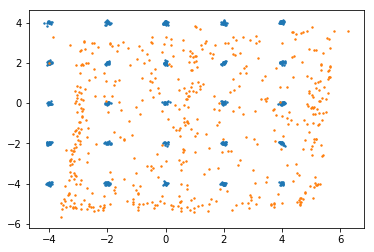

step 2000: discriminator: 6.565e-01, generator: 1.400e+00


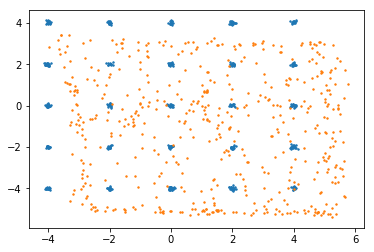

step 3000: discriminator: 5.343e-01, generator: 1.446e+00


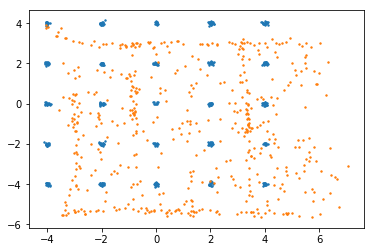

In [7]:
# Basic
generator_basic, discriminator_basic, disc_history_basic, gen_history_basic, real_batch_basic, fake_batch_basic = training_total(options_basic)

step 0: discriminator: 6.891e-01, generator: 6.569e-01


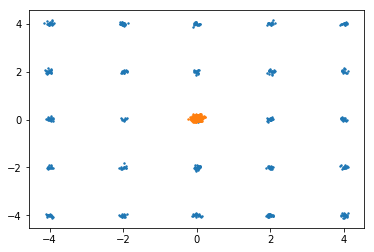

step 1000: discriminator: 4.419e+01, generator: 8.838e+01


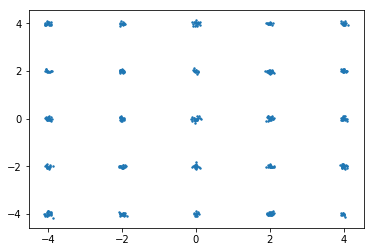

step 2000: discriminator: 4.419e+01, generator: 8.838e+01


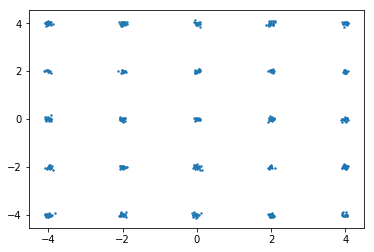

step 3000: discriminator: 4.419e+01, generator: 8.838e+01


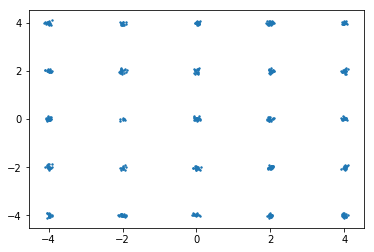

In [8]:
# Shallow Generator + Deep Discriminator
generator_d, discriminator_d, disc_history_d, gen_history_d, real_batch_d, fake_batch_d = training_total(options_deep_disc)

step 0: discriminator: 6.728e-01, generator: 7.068e-01


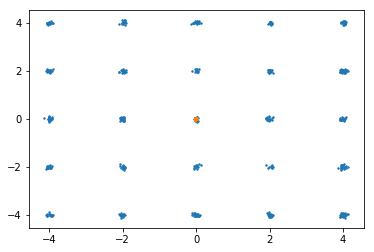

step 1000: discriminator: 6.636e-01, generator: 8.192e-01


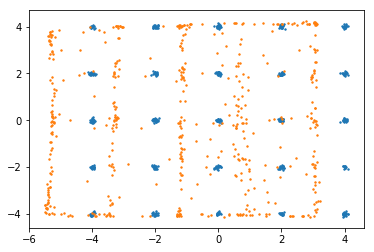

step 2000: discriminator: 6.355e-01, generator: 8.134e-01


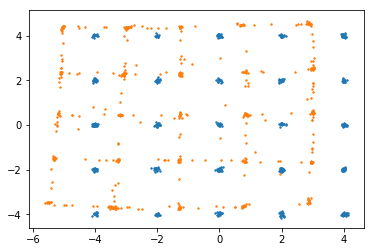

step 3000: discriminator: 6.487e-01, generator: 7.384e-01


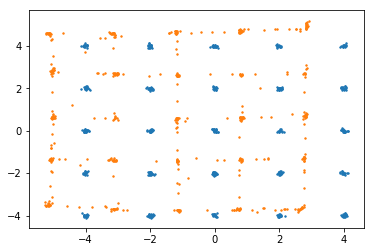

In [9]:
# Deep Generator + Shallow Discriminator
generator_g, discriminator_g, disc_history_g, gen_history_g, real_batch_g, fake_batch_g = training_total(options_deep_gen)

step 0: discriminator: 6.878e-01, generator: 7.044e-01


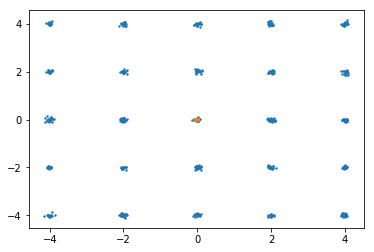

step 1000: discriminator: 2.369e-02, generator: 3.977e+00


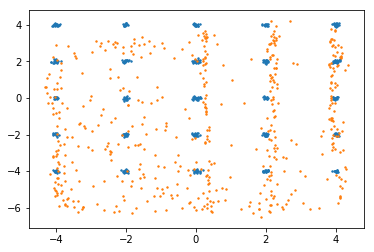

step 2000: discriminator: 4.419e+01, generator: 8.838e+01


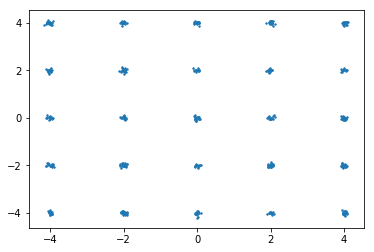

step 3000: discriminator: 4.419e+01, generator: 8.838e+01


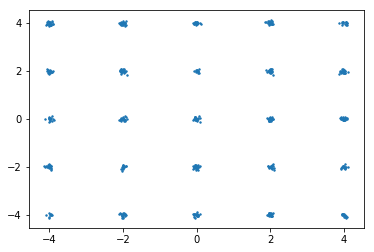

In [11]:
# Deep Discriminator + Deep Generator
generator_dg, discriminator_dg, disc_history_dg, gen_history_dg, real_batch_dg, fake_batch_dg = training_total(options_full)

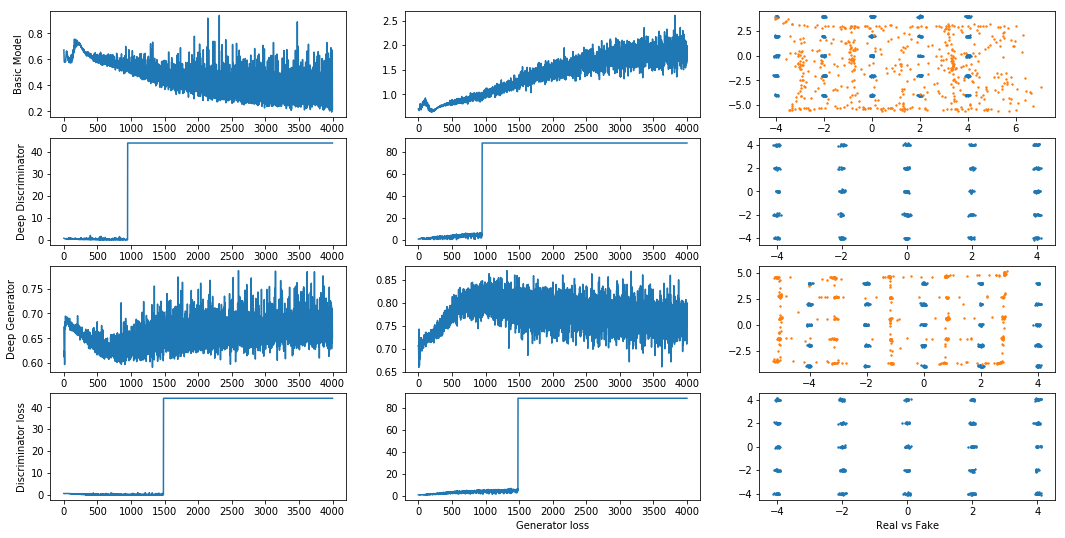

In [44]:
# Plot results GAN
plt.figure(figsize = (18, 9))

plt.subplot(4, 3, 1)
plt.plot(disc_history_basic)
plt.ylabel('Basic Model')

plt.subplot(4, 3, 2)
plt.plot(gen_history_basic)

plt.subplot(4, 3, 3)
plt.scatter(real_batch_basic[:,0], real_batch_basic[:,1], s=2.0, label='Real data')
plt.scatter(fake_batch_basic[:,0], fake_batch_basic[:,1], s=2.0, label='Fake data')

plt.subplot(4, 3, 4)
plt.plot(disc_history_d)
plt.ylabel('Deep Discriminator')

plt.subplot(4, 3, 5)
plt.plot(gen_history_d)

plt.subplot(4, 3, 6)
plt.scatter(real_batch_d[:,0], real_batch_d[:,1], s=2.0, label='Real data')
plt.scatter(fake_batch_d[:,0], fake_batch_d[:,1], s=2.0, label='Fake data')

plt.subplot(4, 3, 7)
plt.plot(disc_history_g)
plt.ylabel('Deep Generator')

plt.subplot(4, 3, 8)
plt.plot(gen_history_g)

plt.subplot(4, 3, 9)
plt.scatter(real_batch_g[:,0], real_batch_g[:,1], s=2.0, label='Real data')
plt.scatter(fake_batch_g[:,0], fake_batch_g[:,1], s=2.0, label='Fake data')

plt.subplot(4, 3, 10)
plt.plot(disc_history_dg)
plt.ylabel('Discriminator loss')

plt.subplot(4, 3, 11)
plt.plot(gen_history_dg)
plt.xlabel('Generator loss')

plt.subplot(4, 3, 12)
plt.scatter(real_batch_dg[:,0], real_batch_dg[:,1], s=2.0, label='Real data')
plt.scatter(fake_batch_dg[:,0], fake_batch_dg[:,1], s=2.0, label='Fake data')
plt.xlabel('Real vs Fake')

plt.show()

With these classes in shape, only the training loop is still missing. To stick with the mathematical GAN framework, we should train the discriminator until convergence between each training step of the generator. This is not practical for two reasons: first it takes a lot of time, and second if the discriminator is too good, its gradient will vanish (as seen in **Q4**) and thus no information will be passed to the generator.

We will then train the discriminator a fixed number of times between each training iteration of the generator.

Complete the previous code and train your model.

Depending on your choice of parameters, the training may not go well at all, with the generator completely collapsing quickly at the beginning of the training. It has been observed by the litterature that the generator's loss $\mathcal{L}_G = \mathbb{E}_{p_\theta} \log(1-D(x))$ is often to blame.

**Q6: Why could we anticipate that this loss could cause this?**

> As discussed in Q4, with this loss, the gradient vanishes when the two distributions are very far, and thus the generator is not able to learn anything.

This issue is solved by replacing the generator loss by an alternative loss: $\mathcal{L}_G = \mathbb{E}_{p_\theta} [ -\log D(x) ]$.

**Q7: Inspect the impact of these different factors:**

- depth / width of the generator network
- depth / width of the discriminator network
- impact of `TRAIN_RATIO`

> 1. I observed that the TRAIN_RATIO was one of the decisive hyperparameters. When set to one, it prevented the models to converge well (I tried several architectures). The GAN began producing visually accurate results when TRAIN_RATIO was equal to 2 to 3. Once TRAIN_RATIO = 3, I observed that it was the difference in power between the Generator and the discriminator that was critical.<br>
> 2. Indeed, the learning process of the GAN can be interpreted through Game theory, where the dicriminator and the generator competes against each other. My take on this is that what matters is that they overall have the same "power" (w.r.t. the `TRAIN_RATIO`). Furthermore, I intuitively think that the Discriminator needs to be a few steps ahead; but not too much because otherwise the discriminator successfully rejects generator samples with high confidence, and the generator’s gradient vanishes. These explains the vanishing gradients in the case 2. and 4. (cf. plot). As for the depth and width of the network, it is significantly important for the generator, that needs to compte with a more trained discriminator.<br>
> 3. However, different configurations should be tested to further support this, as the "results" I obtain are the expression of my own coordinate ascent on the hyperparameters (adjusting to make it work). Nonetheless, I am pretty sure that, an equilibrium (Nash equilibrium?) can be obtained in a more general case by careful balance between the power of the discriminator and the the power of the generator.<br>
> 4. <b>Notes on results:</b> It seems that generated figures are shifted from the original one. I am not sure of why exactly but my guess is it is some form of mode collapse or the discriminator is insensitive to translation.

For further readings on GANs, you can see the following papers:

- Generative Adversarial Networks *(Goodfellow et al.)*: [arXiv:1406.2661](https://arxiv.org/abs/1406.2661)
- Unsupervised Representation Learning with Deep Convolutional Generative Adversarial Networks *(Radford et al.)*: [arXiv:1511.06434](https://arxiv.org/abs/1511.06434)

### Variational AutoEncoders

An other well-known approach to generative modelling is embodied by Variational AutoEncoders (VAEs). While the generative model itself and the procedure to sample it is similar to GANs, the way it is trained is not.

The main goal of VAEs is to optimize the likelihood of the real data according to the generative model. In other words, maximize $\mathbb{E}_{p_D} \log p_\theta(x)$, which is equivalent to minimizing $D_{KL}(p_D \| p_\theta)$.

**Q8: Prove this equivalence.**

> $$
\begin{align}
\text{max}_{\theta}\ \mathbb{E}_{p_D} \log p_\theta(x) &\Leftrightarrow \text{max}_{\theta}\ \sum_x p_D(x) \log p_\theta(x)\\
&\Leftrightarrow \text{max}_{\theta}\ \sum_x p_D(x) \log \big(\frac{p_{\theta}(x)}{p_{D}(x)}*p_{D}(x)\big)\\
&\Leftrightarrow \text{max}_{\theta}\ \sum_x p_D(x) \log \frac{p_{\theta}(x)}{p_{D}(x)} + \sum_{x} p_{D}(x) log p_{D}(x)\\
&\Leftrightarrow \text{max}_{\theta}\ - KL(p_{D}||p_\theta) + \sum_{x} p_{D}(x) log p_{D}(x)\\
&\Leftrightarrow \text{min}_{\theta}\ KL(p_{D}||p_\theta) - \sum_{x} p_{D}(x) log p_{D}(x)\\
&\Leftrightarrow \text{min}_{\theta}\ KL(p_{D}||p_\theta)\\
\end{align}
$$

However, the class of distributions for which $\log p_\theta(x)$ can be analytically computed and optimized is very restricted, and not suitable for real world problems. The main idea of the VAE is thus to introduce a latent variable $z$ and decompose the distribution like so: $p_\theta(x, z) = p_\theta(x | z) p(z)$. Where here $p(z)$ is some fixed prior and $p_\theta(x | z)$ is a simple distribution whose parameters are the output of a neural network.

For example, you could have $p(z)$ be a standard $\mathcal{N}(0;1)$ and $p_\theta(x | z)$ be defined as a gaussian $\mathcal{N}(\mu_\theta(z); \sigma_\theta(z))$ where $\mu_\theta(z)$ and $\sigma_\theta(z)$ are created by the neural network you will train. In this case, the resulting distribution $p_\theta(x) = \int_z p_\theta(x|z)p(z)ds$ is an infinite mixture of gaussians, which is a much more expressive class of distributions.

Now, this cannot stop here, as we are not able to analitically compute the density $p_\theta(x)$. The second main idea of the VAE is to introduce an other, auxilliary distribution: $q_\phi(z | x)$, which will be modelled by a neural network similarly to $p_\theta(x | z)$. Introducing it allows us to create a lower bound for $\log p_\theta(x)$:

$$\log p_\theta(x) = \mathbb{E}_{z \sim q_\phi} \log p_\theta(x) = \mathbb{E}_{z \sim q_\phi} \left[ \log p_\theta(x) \frac {q_\phi(z|x)}{q_\phi(z|x)} \right]$$

Following Bayes theorem, $p_\theta(x) p_\theta(z|x) = p_\theta(x, z) = p_\theta(x|z) p(z)$, so we get:

$$\log p_\theta(x) = \mathbb{E}_{z \sim q_\phi} \left[ \log \frac{p_\theta(x|z) p(z)}{p_\theta(z|x)} \frac {q_\phi(z|x)}{q_\phi(z|x)} \right]$$

Re-organizing the terms:

$$\log p_\theta(x) = \mathbb{E}_{z \sim q_\phi} \log \frac{q_\phi(z|x)}{p_\theta(z|x)} - \mathbb{E}_{z \sim q_\phi} \log \frac{p(z)}{q_\phi(z|x)} + \mathbb{E}_{z \sim q_\phi} \log p_\theta(x | z)$$

This can be re-expressed like so:

$$\log p_\theta(x) = D_{KL}(q_\phi(z | x) \| p_\theta(z | x)) - D_{KL}(q_\phi(z | x) \| p(z)) + \mathbb{E}_{z \sim q_\phi} \log p_\theta(x|z)$$

The 3 terms of this equality can be interpreted like so:

- the first term measures how much $q_\phi(z | x)$ is similar to $p_\theta(z | x)$, or in other words is a good inverse of $p_\theta(x | z)$
- the second term measures how similar $q_\phi(z|x)$ is from the latent prior $p(z)$
- the third term is linked to how likely $p_\theta$ is to yield the given $x$ when $z$ is sampled from $q_\phi(z | x)$ rather than $p(z)$

It is interesting to note that the first term, being a KL-divergence is always positive. As such the combination of the last two terms form a lower bound of $\log p_\theta(x)$ which *can* be computed and used as a training objective. This bound is called the *Evidence Lower-Bound (ELBO)*. Simply flipping its sign can make it into a loss that can be minimized by gradient descent:

$$ \mathcal{L}_{ELBO} = D_{KL}(q_\phi(z | x) \| p(z)) + \mathbb{E}_{z \sim q_\phi} [ - \log p_\theta(x|z) ]$$

From this formulation comes the parallel with auto-encoders that give the VAE its name: $q_\phi(z | x)$ can be seen as a *probabilistic encoder* from the data $x$ to the latent space $z$, and $p_\theta(x | z)$ can be seen as a *probabilistic decoder* from the latent space $z$ to the data $x$. In this case the second term of $\mathcal{L}_{ELBO}$ is the loss measuring the reconstruction quality of the auto-encoder, and the first term can be seens as a regularization of the latent space.

**Q9: We can see that $p(z)$ is never sampled during the training process, how can that be a problem?**

> Because the VAE assumes that there is no simple interpretation of the dimensions of $z$, and instead assert that samples of $z$ can be drawn from a simple distribution, i.e., $\mathcal{N} (0, I)$, we can not be sure of the correcteness of the representation.<br>
> The exact reason behind this issue is that one of the key feature of VAE leverages the following: <b>Any distribution in $d$ dimensions can be generated by taking a set of $d$ variables that are normally distributed and mapping them through a sufficiently complicated function [1]</b>.<br>
> Hence, provided powerful function approximators, we can simply learn a function which maps our independent, normally-distributed $z$ values to whatever latent variables might be needed for the model, and then map those latent variables to $X$.<br>
> Nonetheless, as we do not have direct access to $p(z)$ and we estimate it with a proxy $q_{\phi}$ on the data $X$, we have no guarantees to obtain a solution that generalizes well on new data. Such an approximation might be prone to overfitting.<br>
> <b>Source:</b> See the “inversion method” and the “conditional distribution method” in [Devroye et al](http://www.eirene.de/Devroye.pdf).<br>

A typical choice to represent $q_\phi(z | x)$ is to use a diagonal Gaussian distribution $\mathcal{N}(\mu_\phi(x); Diag(\sigma_\phi(x)))$, which makes the KL-divergence term of $\mathcal{L}_{ELBO}$ analytically computable.

**Q10: Assuming $p(z)$ is a $\mathcal{N}(0; Id)$ gaussian, what is the value of $D_{KL}(q_\phi(z | x) \| p(z))$?**

> For two multivariate Gaussian distributions, the KL divergence can be computed in closed form:
> $$ KL[\mathcal{N}(\mu_{0}, \Sigma_{0}) || \mathcal{N}(\mu_{1}, \Sigma_{1})] = \frac{1}{2}\Big( \text{tr}(\Sigma_{1}^{-1}\Sigma_{0}) + (\mu_{1} - \mu_{0})^{-1} \Sigma_{1}^{-1} (\mu_{1} - \mu_{0}) - N + \text{log}\big( \frac{\mid \Sigma_{1} \mid}{\mid \Sigma_{0} \mid} \big) \Big) $$
> Given that $\mathcal{N}(\mu_{1}, \Sigma_{1}) = \mathcal{N}(0, I)$:
> $$\begin{align} KL[\mathcal{N}(\mu_{0}, \Sigma_{0}) || \mathcal{N}(\mu_{1}, \Sigma_{1})] &= \frac{1}{2}\Big( \text{tr}(\Sigma_{1}^{-1}\Sigma_{0}) + (\mu_{1} - \mu_{0})^{T}  \Sigma_{1}^{-1} (\mu_{1} - \mu_{0}) - N + \text{log}\big( \frac{\mid \Sigma_{1} \mid}{|\Sigma_{0}|} \big) \Big)\\
&= \frac{1}{2}\Big( \text{tr}(\Sigma_{0}) + \mu_{0}^{2} - N - \text{log}(\mid \Sigma_{0} \mid) \Big)\\
&= \frac{1}{2}\Big( \sum_{i=1}^{N}\sigma_{i}^{2} + \mu_{0}^{2} - N - \sum_{i=1}^{N}\text{log } \sigma_{i}^{2} \Big)\\
\end{align} $$

We will also model $p_\theta(x | z)$ as a diagonal Gaussian $\mathcal{N}(\mu_\theta(z); Diag(\sigma_\theta(z)))$.

**Q11: What is the expression of $-\log p_\theta(x | z)$ for given $x$ and $z$?**

> Given that $p_{\theta}(x \mid z) \sim \mathcal{N}(\mu_\theta(z); Diag(\sigma_\theta(z)))$, we have that for a given $x$ and $z$:
> $$ \begin{align}
-\ \text{log}(p_{\theta}(x \mid z)) &= -\ \text{log} \Bigg( \frac{1}{(2\pi)^{N/2}\mid \Sigma \mid^{1/2}} \ exp (-\frac{1}{2}(x-\mu)^{T}\Sigma^{-1}(x-\mu) \Bigg)\\
&= -\ \text{log} \ \text{exp} \Big(-\frac{1}{2}(x-\mu)^{T}\Sigma^{-1}(x-\mu) \Big) - \text{log} \Bigg( \frac{1}{(2\pi)^{N/2}\mid \Sigma \mid^{1/2}}\Bigg)\\
&= \frac{1}{2}(x-\mu)^{T}\Sigma^{-1}(x-\mu)  +\text{log} \bigg((2\pi)^{N/2}\mid \Sigma \mid^{1/2}\bigg)\\
&= \frac{1}{2} \Big( (x-\mu)^{T}\Sigma^{-1}(x-\mu) + \sum_{i=1}^{N}log(\sigma_{i}^{2}) + N \ \text{log}(2\pi) \Big)\\
\end{align} $$
> where $N$ is the latent dimension and we used that given $\Sigma = diag(\sigma_{1:N}^{2})$:
> - $\mid \Sigma \mid = \Pi_{i=1}^{N}\sigma_{i}^{2}$
> - $\Sigma^{-1}$ is diagonal and $\Sigma^{-1}_{ii} = \frac{1}{\sigma_{i}^{2}}$


In [13]:
def reconstruction_loss(x_r, x, mu, logvar, batch_size = 128):
    
    log_term = torch.sum(logvar) 
    sigma = logvar.mul(0.5).exp_()
    distance = torch.sum(((x - mu) / sigma) ** 2) 
    
    return(.5 * (log_term + distance) / batch_size)

We will build and train a VAE using the same dataset as previously, in order to compare its behavior to GANs. For numerical stability, we will interpret the output of the encoder and decoder networks as $(\mu, \log\sigma^2)$, rather than $(\mu, \sigma)$.

In [14]:
# Define the generator
class Encoder(nn.Module):
    def __init__(self, latent_n, layers, activation = "leaky"):
        super().__init__()
        # Architecture
        self.layers = layers

        # Linear units + BatchNorm
        self.fc1 = nn.Linear(2, layers[0])
        self.bn1 = nn.BatchNorm1d(layers[0])

        self.fc2 = nn.Linear(layers[0], layers[1])
        self.bn2 = nn.BatchNorm1d(layers[1])

        # Non linear unit
        if activation == "leaky": self.activation = nn.LeakyReLU(0.2)
        else: self.activation = nn.ReLU()

        # Parameters unit
        self.fc_mu = nn.Linear(layers[-1], latent_n)
        self.fc_logvar = nn.Linear(layers[-1], latent_n)

    # encode a datapoint. This should return a couple of tensors (mu, logvar) representing
    # the parameters of the gaussian q_\phi(z | x)
    def __call__(self, x, leaky = False):

        h1 = self.activation(self.bn1(self.fc1(x)))
        h2 = self.activation(self.bn2(self.fc2(h1)))

        mu = self.fc_mu(h2)
        logvar = self.fc_logvar(h2)
        return (mu, logvar)


# Define the discriminator
class Decoder(nn.Module):
    def __init__(self, latent_n, layers, activation = "leaky"):
        super().__init__()

        # Architecture
        self.layers = layers
        self.latent_n = latent_n

        # Linear units + BatchNorm
        self.fc1 = nn.Linear(latent_n, layers[0])
        self.bn1 = nn.BatchNorm1d(layers[0])

        self.fc2 = nn.Linear(layers[0], layers[1])
        self.bn2 = nn.BatchNorm1d(layers[1])

        # Non linear unit
        if activation == "leaky": self.activation = nn.LeakyReLU(0.2)
        else: self.activation = nn.ReLU()

        # Parameters unit
        self.fc_mu = nn.Linear(layers[-1], 2)
        self.fc_logvar = nn.Linear(layers[-1], 2)

    # decode a datapoint. This should return a couple of tensors (mu, logvar) representing
    # the parameters of the gaussian p_\theta(z | x)
    def __call__(self, z, leaky = False):

        h1 = self.activation(self.bn1(self.fc1(z)))
        h2 = self.activation(self.bn2(self.fc2(h1)))

        mu = self.fc_mu(h2)
        logvar = self.fc_logvar(h2)
        return (mu, logvar)

    def generate(self, batchlen):
        z = torch.normal(torch.zeros(batchlen, self.latent_n), 1.0)
        (mu, logvar) = self.__call__(z)
        return torch.normal(mu, torch.exp(0.5*logvar))


In [15]:
# Define the generator
class DeepEncoder(nn.Module):
    def __init__(self, latent_n, layers, activation = "leaky"):
        super().__init__()
        # Architecture
        self.layers = layers

        # Linear units + BatchNorm
        self.fc1 = nn.Linear(2, layers[0])
        self.bn1 = nn.BatchNorm1d(layers[0])

        self.fc2 = nn.Linear(layers[0], layers[1])
        self.bn2 = nn.BatchNorm1d(layers[1])

        self.fc3 = nn.Linear(layers[1], layers[2])
        self.bn3 = nn.BatchNorm1d(layers[2])

        self.fc4 = nn.Linear(layers[2], layers[3])
        self.bn4 = nn.BatchNorm1d(layers[3])

        self.fc5 = nn.Linear(layers[3], layers[4])
        self.bn5 = nn.BatchNorm1d(layers[4])

        # Non linear unit
        if activation: self.activation = nn.LeakyReLU(0.2)
        else: self.activation = nn.ReLU()

        # Parameters unit
        self.fc_mu = nn.Linear(layers[-1], latent_n)
        self.fc_logvar = nn.Linear(layers[-1], latent_n)

    # encode a datapoint. This should return a couple of tensors (mu, logvar) representing
    # the parameters of the gaussian q_\phi(z | x)
    def __call__(self, x):

        h1 = self.activation(self.bn1(self.fc1(x)))
        h2 = self.activation(self.bn2(self.fc2(h1)))
        h3 = self.activation(self.bn3(self.fc3(h2)))
        h4 = self.activation(self.bn4(self.fc4(h3)))
        h5 = self.activation(self.bn5(self.fc5(h4)))

        mu = self.fc_mu(h5)
        logvar = self.fc_logvar(h5)
        return (mu, logvar)


# Define the discriminator
class DeepDecoder(nn.Module):
    def __init__(self, latent_n, layers, activation = "leaky"):
        super().__init__()

        # Architecture
        self.layers = layers
        self.latent_n = latent_n

        # Linear units + BatchNorm
        self.fc1 = nn.Linear(latent_n, layers[0])
        self.bn1 = nn.BatchNorm1d(layers[0])

        self.fc2 = nn.Linear(layers[0], layers[1])
        self.bn2 = nn.BatchNorm1d(layers[1])

        self.fc3 = nn.Linear(layers[1], layers[2])
        self.bn3 = nn.BatchNorm1d(layers[2])

        self.fc4 = nn.Linear(layers[2], layers[3])
        self.bn4 = nn.BatchNorm1d(layers[3])

        self.fc5 = nn.Linear(layers[3], layers[4])
        self.bn5 = nn.BatchNorm1d(layers[4])

        # Non linear unit
        if activation: self.activation = nn.LeakyReLU(0.2)
        else: self.activation = nn.ReLU()

        # Parameters unit
        self.fc_mu = nn.Linear(layers[-1], 2)
        self.fc_logvar = nn.Linear(layers[-1], 2)

    # decode a datapoint. This should return a couple of tensors (mu, logvar) representing
    # the parameters of the gaussian p_\theta(z | x)
    def __call__(self, z, leaky = False):

        h1 = self.activation(self.bn1(self.fc1(z)))
        h2 = self.activation(self.bn2(self.fc2(h1)))
        h3 = self.activation(self.bn3(self.fc3(h2)))
        h4 = self.activation(self.bn4(self.fc4(h3)))
        h5 = self.activation(self.bn5(self.fc5(h4)))

        mu = self.fc_mu(h5)
        logvar = self.fc_logvar(h5)
        return (mu, logvar)

    def generate(self, batchlen):
        z = torch.normal(torch.zeros(batchlen, self.latent_n), 1.0)
        (mu, logvar) = self.__call__(z)
        return torch.normal(mu, torch.exp(0.5*logvar))


From this, the parameters of both networks are trained conjointly using the same loss $\mathcal{L}_{ELBO}$. Pytorch allows us to sample the Gaussian distribution in a differentiable way using `torch.normal(mu, sigma)`, but it is not differentiable wrt to its inputs.

**Q12: How can you sample a distribution $\mathcal{N}(\mu, \sigma)$ is a way that is differentiable w.r.t. both $\mu$ and $\sigma$?**

> According to the original paper (Section 2.4), $z = \mu + \sigma \epsilon$, where $\epsilon \sim \mathcal{N}(0, 1)$

In [32]:
def vae_training(options_vae, plot_progress = False):
    # Define encoder (+ adam optimizer) and decoder (+ adam optimizer)
    if options_vae['DEEP_ENCODER']:
        encoder = DeepEncoder(options_vae['LATENT_N'], layers = options_vae['ENCODER_ARCHI'], activation = options_vae['LEAKY'])
    else:
        encoder = Encoder(options_vae['LATENT_N'], layers = options_vae['ENCODER_ARCHI'])
        
    if options_vae['DEEP_DECODER']:
        decoder = DeepDecoder(options_vae['LATENT_N'], layers = options_vae['DECODER_ARCHI'], activation = options_vae['LEAKY'])
    else:
        decoder = Decoder(options_vae['LATENT_N'], layers = options_vae['DECODER_ARCHI'])
    
    # Optimizers
    optim_enc = torch.optim.Adam(encoder.parameters(), lr=0.01, betas=(0.5,0.9))
    optim_dec = torch.optim.Adam(decoder.parameters(), lr=0.01, betas=(0.5,0.9))
    
    # Loss history
    kl_history = []
    reconstruction_history = []
    
    for i in range(options_vae['N_ITER']):
        # Forward pass
        optim_enc.zero_grad()
        optim_dec.zero_grad()

        # Generate batch and encode it - yielding parameters mu and var
        x = generate_batch(options_vae['BATCHLEN'])
        enc_mu, enc_logvar = encoder(x)

        # <TO FILL> Compute here the DKL part of the VAE loss
        loss_kl = torch.sum(0.5 * (enc_mu**2 + torch.exp(enc_logvar) - enc_logvar - 1))
        loss_kl /= options_vae['BATCHLEN']
        kl_history.append(loss_kl.detach())

        # <TO FILL> Sample z with reparameterization trick
        std = enc_logvar.exp().sqrt()
        eps = torch.randn_like(std)
        z = eps.mul(std).add_(enc_mu)

        # Decoder and sampling
        dec_mu, dec_logvar = decoder(z)
        if options_vae['HARDCODE']: dec_logvar = torch.log(0.01*torch.ones(dec_logvar.shape))

        # <TO FILL> Sample solution
        x_r = torch.normal(dec_mu, torch.exp(0.5*dec_logvar))

        # Reconstruction loss    
        loss_rec = reconstruction_loss(x_r, x, dec_mu, dec_logvar, batch_size = options_vae['BATCHLEN'])
        reconstruction_history.append(loss_rec.detach())

        # Backward pass
        (loss_kl + loss_rec).backward()
        optim_enc.step()
        optim_dec.step()

        # Test the results
        if i%500 == 0 and plot_progress:
            # Verbose
            print('Step {}: KL: {:.3e}, rec: {:.3e}'.format(i, float(loss_kl), float(loss_rec)))

            # Get one real, one reconstructed and one fake batch
            real_batch = generate_batch(options_vae['BATCHLEN'])
            rec_batch = torch.normal(dec_mu, torch.exp(0.5*dec_logvar)).detach()
            fake_batch = decoder.generate(options_vae['BATCHLEN']).detach()

            # Plot the result
            plt.scatter(real_batch[:,0], real_batch[:,1], s=2.0, label='real data')
            plt.scatter(rec_batch[:,0], rec_batch[:,1], s=2.0, label='rec data')
            plt.scatter(fake_batch[:,0], fake_batch[:,1], s=2.0, label='fake data')
            plt.show()
            
    return(kl_history, reconstruction_history, real_batch, rec_batch, dec_mu.detach(), dec_logvar.detach())

In [33]:
vae = {
    # Total number of training iterations for the VAE
    "N_ITER" : 3001,
    # Batch size to use
    "BATCHLEN" : 1024,
    # Choose a value for the latent dimension
    "LATENT_N" : 10,
    # Hardcode sigma
    "HARDCODE" : False,
    # Layers encoder
    "ENCODER_ARCHI": [5, 8],
    # Layers encoder
    "DECODER_ARCHI": [8, 5],
    # Activation
    "LEAKY": True,
    # Encoder type
    "DEEP_ENCODER": False,
    "DEEP_DECODER": False
}

vae_hardcode = {
    # Total number of training iterations for the VAE
    "N_ITER" : 3001,
    # Batch size to use
    "BATCHLEN" : 1024,
    # Choose a value for the latent dimension
    "LATENT_N" : 10,
    # Hardcode sigma
    "HARDCODE" : True,
    # Layers encoder
    "ENCODER_ARCHI": [5, 8],
    # Layers encoder
    "DECODER_ARCHI": [8, 5],
    # Activation
    "LEAKY": True,
    # Encoder type
    "DEEP_ENCODER": False,
    "DEEP_DECODER": False
}

vae_depth = {
    # Total number of training iterations for the VAE
    "N_ITER" : 3001,
    # Batch size to use
    "BATCHLEN" : 1024,
    # Choose a value for the latent dimension
    "LATENT_N" : 15,
    # Hardcode sigma
    "HARDCODE" : False,
    # Layers encoder
    "ENCODER_ARCHI": [4, 5, 6, 7, 9],
    # Layers encoder
    "DECODER_ARCHI": [9, 7, 6, 5, 4],
    # Activation
    "LEAKY": True,
    # Encoder type
    "DEEP_ENCODER": True,
    "DEEP_DECODER": True
}

vae_depth_hardcode = {
    # Total number of training iterations for the VAE
    "N_ITER" : 3001,
    # Batch size to use
    "BATCHLEN" : 1024,
    # Choose a value for the latent dimension
    "LATENT_N" : 15,
    # Hardcode sigma
    "HARDCODE" : True,
    # Layers encoder
    "ENCODER_ARCHI": [4, 5, 6, 7, 9],
    # Layers encoder
    "DECODER_ARCHI": [9, 7, 6, 5, 4],
    # Activation
    "LEAKY": True,
    # Encoder type
    "DEEP_ENCODER": True,
    "DEEP_DECODER": True
}

Step 0: KL: 5.778e-01, rec: 8.275e+00


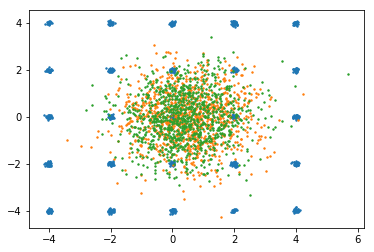

Step 500: KL: 1.600e+00, rec: 9.960e-01


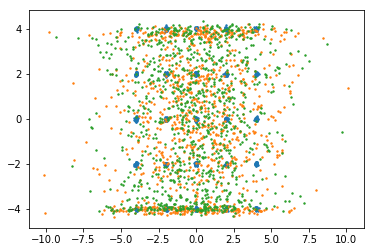

Step 1000: KL: 1.690e+00, rec: 9.554e-01


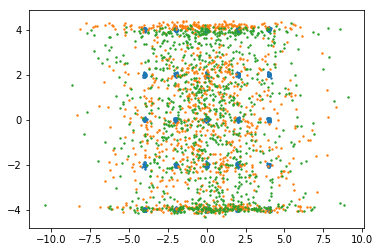

Step 1500: KL: 1.730e+00, rec: 8.924e-01


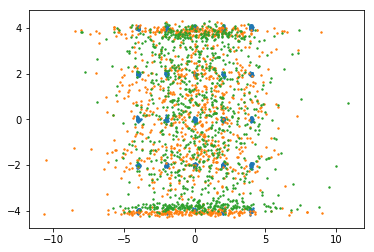

Step 2000: KL: 1.670e+00, rec: 7.066e-01


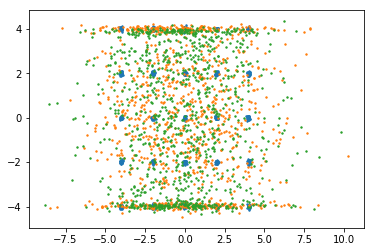

Step 2500: KL: 1.660e+00, rec: 7.565e-01


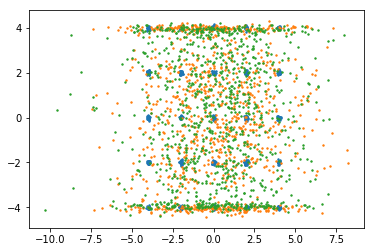

Step 3000: KL: 1.677e+00, rec: 6.885e-01


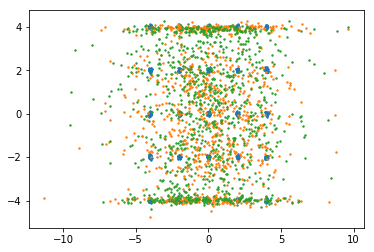

Step 0: KL: 6.917e-01, rec: 8.152e+02


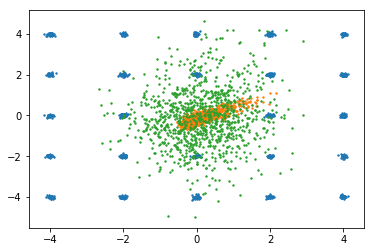

Step 500: KL: 6.549e+00, rec: -2.673e+00


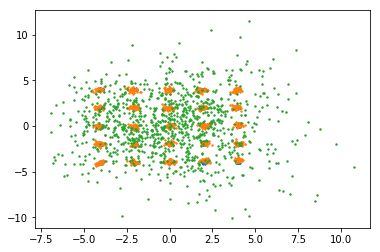

Step 1000: KL: 6.612e+00, rec: -1.757e+00


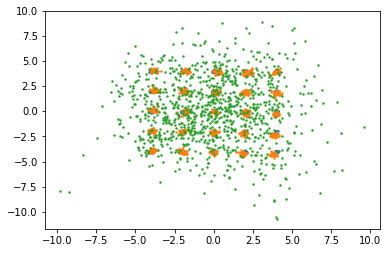

Step 1500: KL: 6.531e+00, rec: 9.265e-02


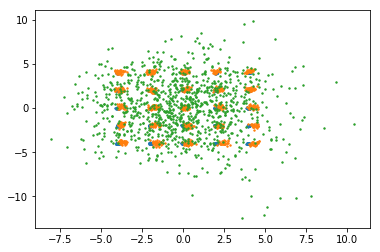

Step 2000: KL: 6.518e+00, rec: -2.194e+00


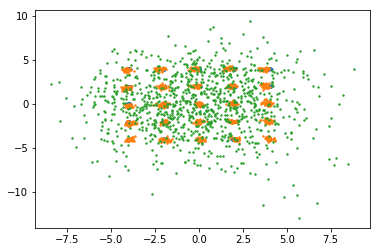

Step 2500: KL: 6.529e+00, rec: -2.390e+00


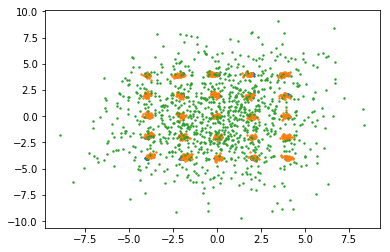

Step 3000: KL: 6.450e+00, rec: -8.456e-01


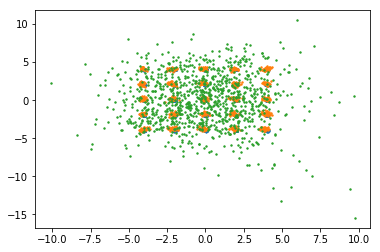

Step 0: KL: 8.931e-01, rec: 7.335e+00


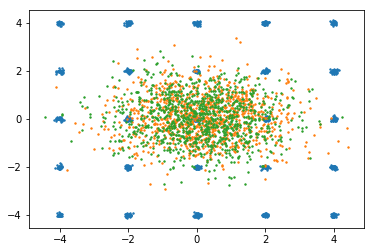

Step 500: KL: 1.743e+00, rec: 6.362e-01


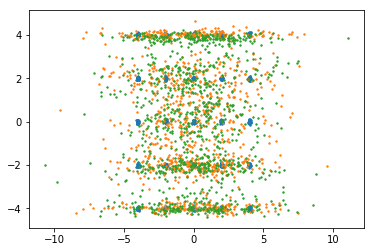

Step 1000: KL: 2.107e+00, rec: 9.000e-02


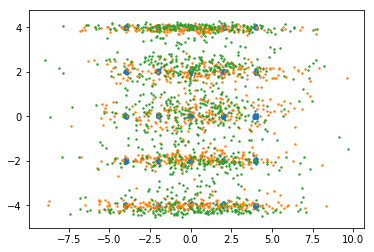

Step 1500: KL: 2.102e+00, rec: 4.536e-01


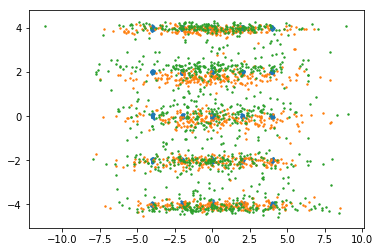

Step 2000: KL: 1.910e+00, rec: 9.965e-02


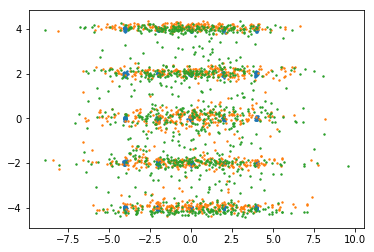

Step 2500: KL: 2.018e+00, rec: 5.241e-02


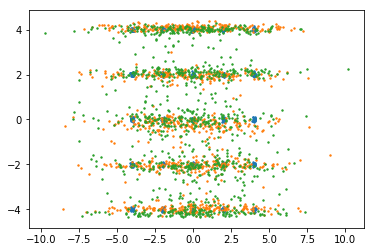

Step 3000: KL: 2.100e+00, rec: 3.249e-01


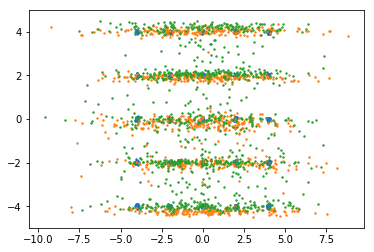

Step 0: KL: 6.154e-01, rec: 7.894e+02


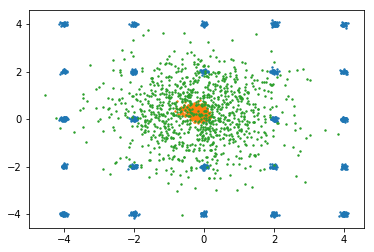

Step 500: KL: 7.317e+00, rec: -6.701e-01


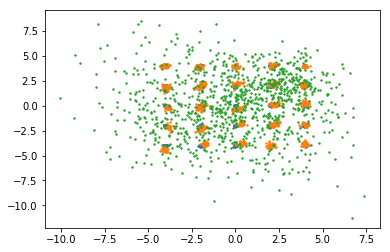

Step 1000: KL: 6.645e+00, rec: -1.391e+00


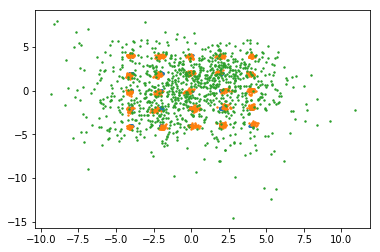

Step 1500: KL: 6.564e+00, rec: -3.029e+00


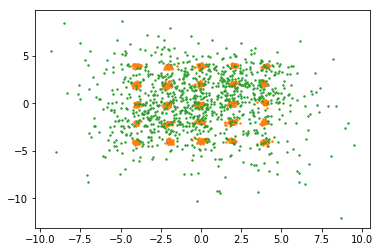

Step 2000: KL: 6.412e+00, rec: -7.558e-01


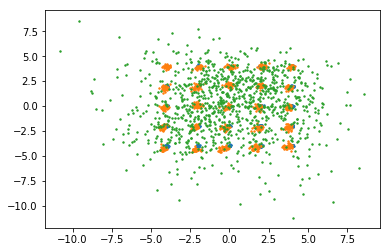

Step 2500: KL: 6.326e+00, rec: 9.428e-01


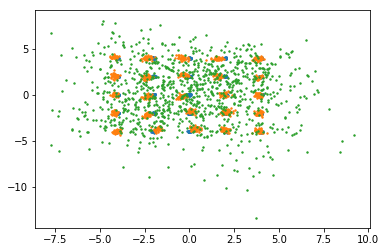

Step 3000: KL: 6.268e+00, rec: -2.187e+00


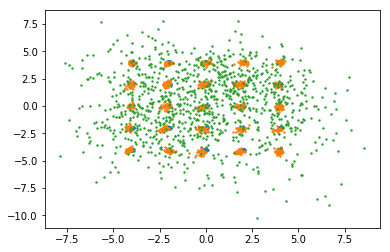

In [37]:
# Leaky Relu
kl_history_vae_l, reconstruction_history_vae_l, real_batch_vae_l, fake_batch_vae_l, mu_vae_l, logvar_vae_l = vae_training(vae, plot_progress = True)
kl_history_vae_hc_l, reconstruction_history_vae_hc_l, real_batch_vae_hc_l, fake_batch_vae_hc_l, mu_vae_hc_l, logvar_vae_hc_l = vae_training(vae_hardcode, plot_progress = True)
kl_history_deep_l, reconstruction_history_deep_l, real_batch_deep_l, fake_batch_deep_l, mu_deep_l, logvar_deep_l = vae_training(vae_depth, plot_progress = True)
kl_history_deep_hc_l, reconstruction_history_deep_hc_l, real_batch_deep_hc_l, fake_batch_deep_hc_l, mu_deep_hc_l, logvar_deep_hc_l = vae_training(vae_depth_hardcode, plot_progress = True)

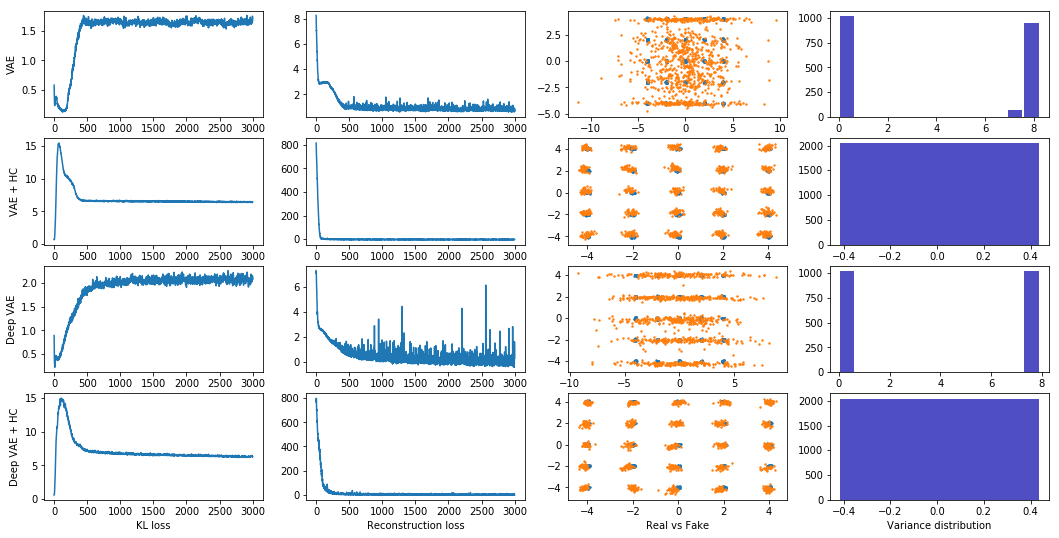

In [38]:
# Plot results VAE
plt.figure(figsize = (18, 9))

plt.subplot(4, 4, 1)
plt.plot(kl_history_vae_l)
plt.ylabel('VAE')

plt.subplot(4, 4, 2)
plt.plot(reconstruction_history_vae_l)

plt.subplot(4, 4, 3)
plt.scatter(real_batch_vae_l[:,0], real_batch_vae_l[:,1], s=2.0, label='Real data')
plt.scatter(fake_batch_vae_l[:,0], fake_batch_vae_l[:,1], s=2.0, label='Fake data')

plt.subplot(4, 4, 4)
plt.hist(x = np.exp(logvar_vae_l.flatten()), bins = 'auto', color = '#0504aa', alpha = 0.7, rwidth = 0.85)

plt.subplot(4, 4, 5)
plt.plot(kl_history_vae_hc_l)
plt.ylabel('VAE + HC')

plt.subplot(4, 4, 6)
plt.plot(reconstruction_history_vae_hc_l)

plt.subplot(4, 4, 7)
plt.scatter(real_batch_vae_hc_l[:,0], real_batch_vae_hc_l[:,1], s=2.0, label='Real data')
plt.scatter(fake_batch_vae_hc_l[:,0], fake_batch_vae_hc_l[:,1], s=2.0, label='Fake data')

plt.subplot(4, 4, 8)
plt.hist(x = np.exp(logvar_vae_hc_l.flatten()), bins = 'auto', color = '#0504aa', alpha = 0.7, rwidth = 0.85)

plt.subplot(4, 4, 9)
plt.plot(kl_history_deep_l)
plt.ylabel('Deep VAE')

plt.subplot(4, 4, 10)
plt.plot(reconstruction_history_deep_l)

plt.subplot(4, 4, 11)
plt.scatter(real_batch_deep_l[:,0], real_batch_deep_l[:,1], s=2.0, label='Real data')
plt.scatter(fake_batch_deep_l[:,0], fake_batch_deep_l[:,1], s=2.0, label='Fake data')

plt.subplot(4, 4, 12)
plt.hist(x = np.exp(logvar_deep_l.flatten()), bins = 'auto', color = '#0504aa', alpha = 0.7, rwidth = 0.85)

plt.subplot(4, 4, 13)
plt.plot(kl_history_deep_hc_l)
plt.ylabel('Deep VAE + HC')
plt.xlabel('KL loss')

plt.subplot(4, 4, 14)
plt.plot(reconstruction_history_deep_hc_l)
plt.xlabel('Reconstruction loss')

plt.subplot(4, 4, 15)
plt.scatter(real_batch_deep_hc_l[:,0], real_batch_deep_hc_l[:,1], s=2.0, label='Real data')
plt.scatter(fake_batch_deep_hc_l[:,0], fake_batch_deep_hc_l[:,1], s=2.0, label='Fake data')
plt.xlabel('Real vs Fake')

plt.subplot(4, 4, 16)
plt.hist(x = np.exp(logvar_deep_hc_l.flatten()), bins = 'auto', color = '#0504aa', alpha = 0.7, rwidth = 0.85)
plt.xlabel('Variance distribution')

plt.show()

**Q13: Try hardcoding $\sigma_\theta(z)$ to some small value (like 0.01) rather than allowing the decoder to learn it. What does it change?**

> Hardcoding $\sigma_\theta(z)$ to some small value forces the mixture of Gaussian (see our latent distribution) to be blind to patterns with large variance (directions of the grid). In consequence: 
> - KL divergence loss is worse, because the variances induce less error when fixed. I suspect that when the variances are not hardcoded, the large patterns in the image tend to be major contributor of the KL loss (because there are modeled by large Gaussian). Refer to the Variance distribution plots above for support.
> - Reconstruction loss is much lower compared to when the VAE learns the variance. I attribute this to the overfitting induced by small variances.

**Q14: How do the power of encoder and decoder affect the overall training of the VAE?**

In [39]:
vae_deep_decoder = {
    # Total number of training iterations for the VAE
    "N_ITER" : 3001,
    # Batch size to use
    "BATCHLEN" : 1024,
    # Choose a value for the latent dimension
    "LATENT_N" : 10,
    # Hardcode sigma
    "HARDCODE" : False,
    # Layers encoder
    "ENCODER_ARCHI": [5, 8],
    # Layers encoder
    "DECODER_ARCHI": [9, 7, 6, 5, 4],
    # Activation
    "LEAKY": True,
    # Encoder type
    "DEEP_ENCODER": False,
    "DEEP_DECODER": True
}

vae_deep_encoder = {
    # Total number of training iterations for the VAE
    "N_ITER" : 3001,
    # Batch size to use
    "BATCHLEN" : 1024,
    # Choose a value for the latent dimension
    "LATENT_N" : 10,
    # Hardcode sigma
    "HARDCODE" : False,
    # Layers encoder
    "ENCODER_ARCHI": [4, 5, 6, 7, 9],
    # Layers encoder
    "DECODER_ARCHI": [8, 5],
    # Activation
    "LEAKY": True,
    # Encoder / Decoder type
    "DEEP_ENCODER": True,
    "DEEP_DECODER": False
}

Step 0: KL: 1.034e+00, rec: 1.258e+01


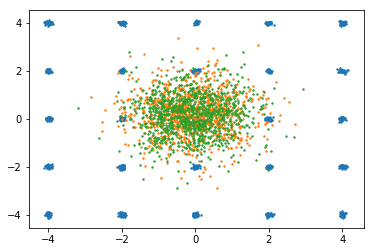

Step 500: KL: 1.529e+00, rec: 1.023e+00


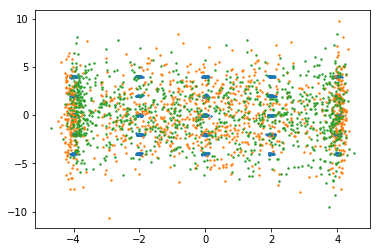

Step 1000: KL: 1.614e+00, rec: 1.008e+00


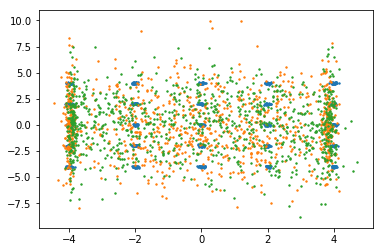

Step 1500: KL: 1.637e+00, rec: 7.762e-01


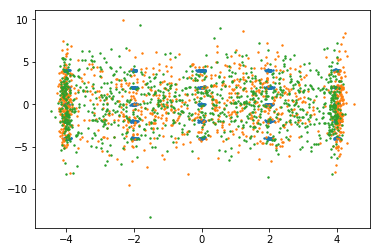

Step 2000: KL: 1.656e+00, rec: 1.516e+00


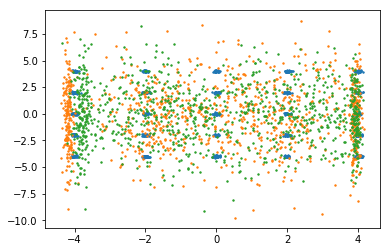

Step 2500: KL: 1.634e+00, rec: 6.954e-01


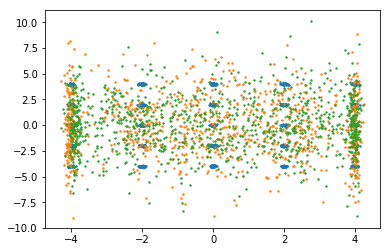

Step 3000: KL: 1.655e+00, rec: 8.835e-01


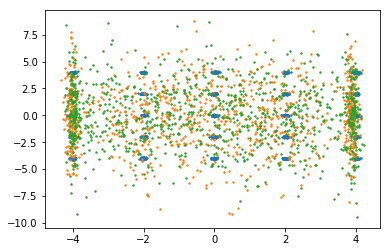

Step 0: KL: 1.077e+00, rec: 1.183e+01


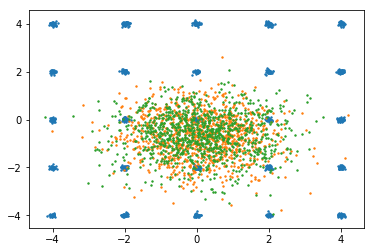

Step 500: KL: 1.413e+00, rec: 1.598e+00


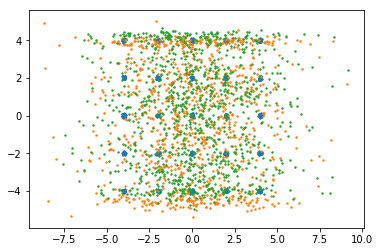

Step 1000: KL: 1.762e+00, rec: 9.785e-01


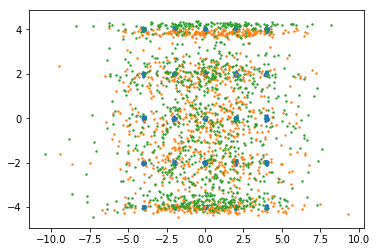

Step 1500: KL: 1.854e+00, rec: 3.978e-01


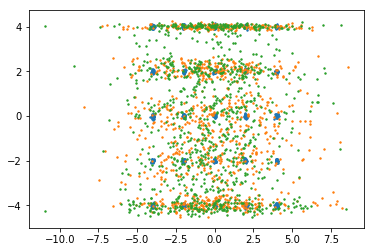

Step 2000: KL: 1.957e+00, rec: 4.763e-01


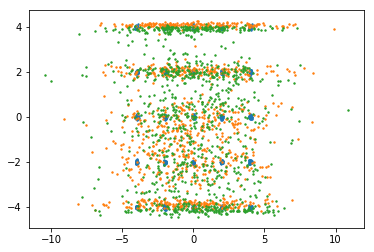

Step 2500: KL: 1.871e+00, rec: 5.273e-01


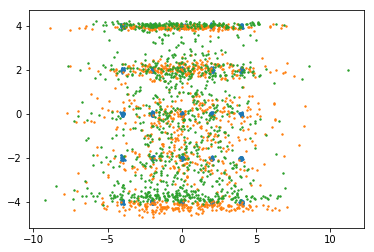

Step 3000: KL: 1.939e+00, rec: 6.631e-01


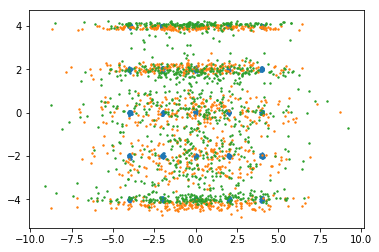

In [40]:
kl_history_deep_enc, reconstruction_history_deep_enc, real_batch_deep_enc, fake_batch_deep_enc, mu_deep_enc, logvar_deep_enc = vae_training(vae_deep_encoder, plot_progress = True)
kl_history_deep_dec, reconstruction_history_deep_dec, real_batch_deep_dec, fake_batch_deep_dec, mu_deep_dec, logvar_deep_dec = vae_training(vae_deep_decoder, plot_progress = True)

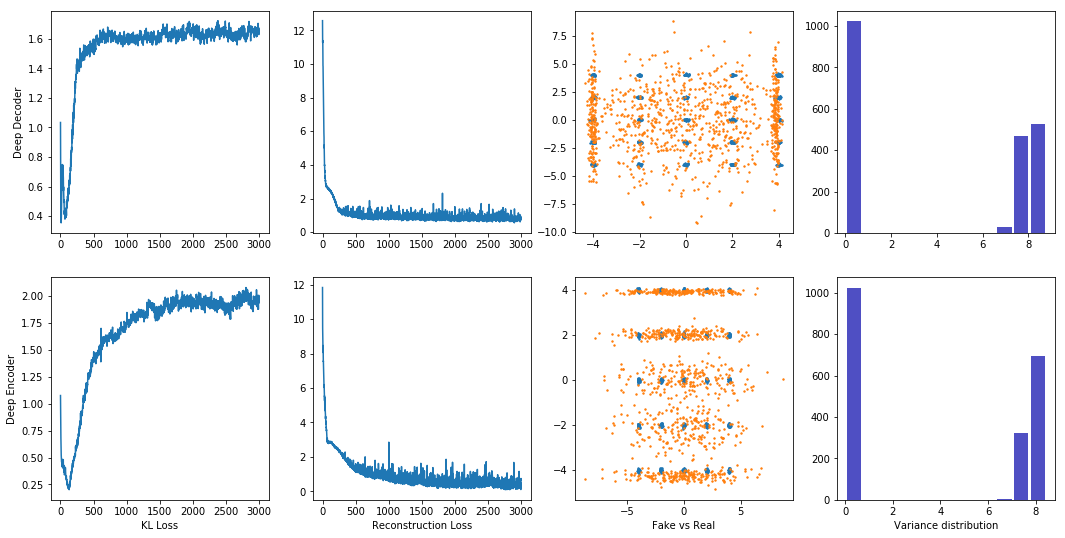

In [41]:
# Plot results VAE
plt.figure(figsize = (18, 9))

plt.subplot(2, 4, 1)
plt.plot(kl_history_deep_enc)
plt.ylabel('Deep Decoder')

plt.subplot(2, 4, 2)
plt.plot(reconstruction_history_deep_enc)

plt.subplot(2, 4, 3)
plt.scatter(real_batch_deep_enc[:,0], real_batch_deep_enc[:,1], s=2.0, label='Real data')
plt.scatter(fake_batch_deep_enc[:,0], fake_batch_deep_enc[:,1], s=2.0, label='Fake data')

plt.subplot(2, 4, 4)
plt.hist(x = np.exp(logvar_deep_enc.flatten()), bins = 'auto', color = '#0504aa', alpha = 0.7, rwidth = 0.85)

plt.subplot(2, 4, 5)
plt.plot(kl_history_deep_dec)
plt.ylabel('Deep Encoder')
plt.xlabel('KL Loss')

plt.subplot(2, 4, 6)
plt.plot(reconstruction_history_deep_dec)
plt.xlabel('Reconstruction Loss')

plt.subplot(2, 4, 7)
plt.scatter(real_batch_deep_dec[:,0], real_batch_deep_dec[:,1], s=2.0, label='Real data')
plt.scatter(fake_batch_deep_dec[:,0], fake_batch_deep_dec[:,1], s=2.0, label='Fake data')
plt.xlabel('Fake vs Real')

plt.subplot(2, 4, 8)
plt.hist(x = np.exp(logvar_deep_dec.flatten()), bins = 'auto', color = '#0504aa', alpha = 0.7, rwidth = 0.85)
plt.xlabel('Variance distribution')
plt.show()

> As we can see from the above plot, the power of the encoder is more important than the one of the decoder. This makes sense, as once the encoder created a strong latent space (i.e. mixture of gaussian), decoding it is much simpler. In our use case, when the encoder is shallower than the decoder, the decoder has less to learn with and produce less powerful results in consequence.

**Q15: As a conclusion, how would you compare the advantages and shortcomings of GANs and VAEs?**

> They serve different purposes:<br>
> <b>VAE</b> explicit goal is to perform latent modeling of the data, by accounting for of marginalizing out certain variables as part of the modeling process. Though they sometimes make good generations, they are mostly used when the latent space is in itself important. In our use case, it found the axis / direction of the grid (several when the autoencoder is deeper). It indeed naturally collapses most dimensions in the latent representations, thereby producing very interpretable results. Additionally, hardcoding the variances can increase the generations of the VAE.<br>
> <b>GAN</b> however are explicitly designed to optimize for generative tasks, though some recent work try to incorporate a true latent space into them (BiGAN). This explains the more accurate generations in our use case.